# Setup


In [ ]:
credentials = {
  "bucket": "starfish",
  "access_key_id": "d11af1a25afc4a59b2c53432edbfed29",
  "secret_access_key": "4bf5a6eaab833318aa1fa836650f11a44f18deb3ea4a7e1f",
  "endpoint_url": "https://s3.us.cloud-object-storage.appdomain.cloud"
}

In [ ]:
NUM_TRAIN_STEPS = 500
MODEL_TYPE  = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
CONFIG_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync'

import os
CLOUD_ANNOTATIONS_MOUNT = os.path.join('/content', credentials['bucket'])
ANNOTATIONS_JSON_PATH   = os.path.join(CLOUD_ANNOTATIONS_MOUNT, '_annotations.json')

CHECKPOINT_PATH = '/content/checkpoint'
OUTPUT_PATH     = '/content/output'
EXPORTED_PATH   = '/content/exported'
DATA_PATH       = '/content/data'

LABEL_MAP_PATH    = os.path.join(DATA_PATH, 'label_map.pbtxt')
TRAIN_RECORD_PATH = os.path.join(DATA_PATH, 'train.record')
VAL_RECORD_PATH   = os.path.join(DATA_PATH, 'val.record')

# Install the TensorFlow Object Detection API
In order to use the TensorFlow Object Detection API, we need to clone it's GitHub Repo.

### Dependencies
Most of the dependencies required come preloaded in Google Colab. The only additional package we need to install is TensorFlow.js, which is used for converting our trained model to a model that is compatible for the web.

### Protocol Buffers
The TensorFlow Object Detection API relies on what are called `protocol buffers` (also known as `protobufs`). Protobufs are a language neutral way to describe information. That means you can write a protobuf once and then compile it to be used with other languages, like Python, Java or C.

The `protoc` command used below is compiling all the protocol buffers in the `object_detection/protos` folder for Python.

### Environment
To use the object detection api we need to add it to our `PYTHONPATH` along with `slim` which contains code for training and evaluating several widely used Convolutional Neural Network (CNN) image classification models.

In [ ]:
%tensorflow_version 1.x
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
   !git clone --depth 1 https://github.com/cloud-annotations/models

!pip install cloud-annotations==0.0.4
!pip install tf_slim
!pip install lvis
!pip install --no-deps tensorflowjs==1.4.0

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

pwd = os.getcwd()
os.environ['PYTHONPATH'] += f':{pwd}:{pwd}/slim'

/content/models/research


# Test the setup
If everything was set up properly and nothing went wrong, we should be able to run this command.

In [ ]:
!python object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.7.12: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_w

# Mount Cloud Annotations Bucket
In order to use files from Cloud Annotations we need to mount it to Colab.

In [ ]:
import cloud_annotations as ca
ca.mount(CLOUD_ANNOTATIONS_MOUNT, credentials)

starfish mounted


# Generate a Label Map
One piece of data the Object Detection API needs is a label map protobuf. The label map associates an integer id to the text representation of the label. The ids are indexed by 1, meaning the first label will have an id of 1 not 0.

Here is an example of what a label map looks like:
```
item {
  id: 1
  name: 'Cat'
}

item {
  id: 2
  name: 'Dog'
}

item {
  id: 3
  name: 'Gold Fish'
}
```


In [ ]:
import os
import json

# Get a list of labels from the annotations.json
labels = {}
with open(ANNOTATIONS_JSON_PATH) as f:
  annotations = json.load(f)
  labels = annotations['labels']

# Create a file named label_map.pbtxt
os.makedirs(DATA_PATH, exist_ok=True)
with open(LABEL_MAP_PATH, 'w') as f:
  # Loop through all of the labels and write each label to the file with an id
  for idx, label in enumerate(labels):
    f.write('item {\n')
    f.write("\tname: '{}'\n".format(label))
    f.write('\tid: {}\n'.format(idx + 1)) # indexes must start at 1
    f.write('}\n')

In [ ]:
labels

['cots']

# Generate TFRecords
The TensorFlow Object Detection API expects our data to be in the format of TFRecords.

The TFRecord format is a collection of serialized feature dicts, one for each image, looking something like this:
```
{
  'image/height': 1800,
  'image/width': 2400,
  'image/filename': 'image1.jpg',
  'image/source_id': 'image1.jpg',
  'image/encoded': ACTUAL_ENCODED_IMAGE_DATA_AS_BYTES,
  'image/format': 'jpeg',
  'image/object/bbox/xmin': [0.7255949630314233, 0.8845598428835489],
  'image/object/bbox/xmax': [0.9695875693160814, 1.0000000000000000],
  'image/object/bbox/ymin': [0.5820120073891626, 0.1829972290640394],
  'image/object/bbox/ymax': [1.0000000000000000, 0.9662484605911330],
  'image/object/class/text': (['Cat', 'Dog']),
  'image/object/class/label': ([1, 2])
}
```

In [ ]:
#annotations[train_examples[0]]

In [ ]:
#label_map

In [ ]:
import os
import io
import json
import random

import tensorflow as tf
import PIL.Image
from PIL import JpegImagePlugin
JpegImagePlugin._getmp = lambda x: None

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util

def create_tf_record(images, annotations, label_map, image_path, output):
  # Create a train.record TFRecord file.
  with tf.python_io.TFRecordWriter(output) as writer:
    # Loop through all the training examples.
    for image_name in images:
      try:
        # Make sure the image is actually a file
        img_path = os.path.join(image_path, image_name)   
        if not os.path.isfile(img_path):
          continue
          
        # Read in the image.
        with tf.gfile.GFile(img_path, 'rb') as fid:
          encoded_jpg = fid.read()

        # Open the image with PIL so we can check that it's a jpeg and get the image
        # dimensions.
        encoded_jpg_io = io.BytesIO(encoded_jpg)
        image = PIL.Image.open(encoded_jpg_io)
        if image.format != 'JPEG':
          raise ValueError('Image format not JPEG')

        width, height = image.size

        # Initialize all the arrays.
        xmins = []
        xmaxs = []
        ymins = []
        ymaxs = []
        classes_text = []
        classes = []

        # The class text is the label name and the class is the id. If there are 3
        # cats in the image and 1 dog, it may look something like this:
        # classes_text = ['Cat', 'Cat', 'Dog', 'Cat']
        # classes      = [  1  ,   1  ,   2  ,   1  ]

        # For each image, loop through all the annotations and append their values.
        for a in annotations[image_name]:
          if ("x" in a and "x2" in a and "y" in a and "y2" in a):
            label = a['label']
            xmins.append(a["x"])
            xmaxs.append(a["x2"])
            ymins.append(a["y"])
            ymaxs.append(a["y2"])
            classes_text.append(label.encode("utf8"))
            classes.append(label_map[label])
       
        # Create the TFExample.
        tf_example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': dataset_util.int64_feature(height),
          'image/width': dataset_util.int64_feature(width),
          'image/filename': dataset_util.bytes_feature(image_name.encode('utf8')),
          'image/source_id': dataset_util.bytes_feature(image_name.encode('utf8')),
          'image/encoded': dataset_util.bytes_feature(encoded_jpg),
          'image/format': dataset_util.bytes_feature('jpeg'.encode('utf8')),
          'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
          'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
          'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
          'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
          'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
          'image/object/class/label': dataset_util.int64_list_feature(classes),
        }))
        if tf_example:
          # Write the TFExample to the TFRecord.
          writer.write(tf_example.SerializeToString())
      except ValueError as e:
        print(e)
        pass
      except IOError:
        print("Can't read example, ignoring.")
        pass

with open(ANNOTATIONS_JSON_PATH) as f:
  annotations = json.load(f)['annotations']
  image_files = [image for image in annotations.keys()]
  # Load the label map we created.
  label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)

  random.seed(42)
  random.shuffle(image_files)
  num_train = int(0.7 * len(image_files))
  train_examples = image_files[:num_train]
  val_examples = image_files[num_train:]

  create_tf_record(train_examples, annotations, label_map, CLOUD_ANNOTATIONS_MOUNT, TRAIN_RECORD_PATH)
  create_tf_record(val_examples, annotations, label_map, CLOUD_ANNOTATIONS_MOUNT, VAL_RECORD_PATH)

In [ ]:
# x = create_tf_record(train_examples, annotations, label_map, CLOUD_ANNOTATIONS_MOUNT, TRAIN_RECORD_PATH)
# x

# Download a base model
Training a model from scratch can take days and tons of data. We can mitigate this by using a pretrained model checkpoint. Instead of starting from nothing, we can add to what was already learned with our own data.

There are several pretrained model checkpoints that can be downloaded from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).

The model we will be training is the SSD MobileNet architecture. SSD MobileNet models have a very small file size and can execute very quickly, compromising little accuracy, which makes it perfect for running in the browser. Additionally, we will be using `quantization`. When we say the model is `quantized` it means instead of using `float32` as the datatype of our numbers we are using `float16` or `int8`.

- `float32(PI)` = `3.1415927` 32 bits
- `float16(PI)` = `3.14` 16 bits
- `int8(PI)` = `3` 8 bits

We do this because it can cut our model size down by around a factor of 4! An unquantized version of SSD MobileNet that I trained was `22.3 MB`, but the quantized version was `5.7 MB` that's a `~75%` reduction 🎉

In [ ]:
import os
import tarfile

import six.moves.urllib as urllib

download_base = 'http://download.tensorflow.org/models/object_detection/'
model = MODEL_TYPE + '.tar.gz'
tmp = '/content/checkpoint.tar.gz'

if not (os.path.exists(CHECKPOINT_PATH)):
  # Download the checkpoint
  opener = urllib.request.URLopener()
  # ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18.tar.gz
  opener.retrieve(download_base + model, tmp)

  # Extract all the `model.ckpt` files.
  with tarfile.open(tmp) as tar:
    for member in tar.getmembers():
      member.name = os.path.basename(member.name)
      if 'model.ckpt' in member.name:
        tar.extract(member, path=CHECKPOINT_PATH)

  os.remove(tmp)

# Model config
The final thing we need to do is inject our pipline with the amount of labels we have and where to find the label map, TFRecord and model checkpoint. We also need to change the the batch size, because the default batch size of 128 is too large for Colab to handle.

In [ ]:
import re

from google.protobuf import text_format

from object_detection.utils import config_util
from object_detection.utils import label_map_util

pipeline_skeleton = '/content/models/research/object_detection/samples/configs/' + CONFIG_TYPE + '.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_skeleton)

label_map   = label_map_util.get_label_map_dict(LABEL_MAP_PATH)
num_classes = len(label_map.keys())
meta_arch   = configs["model"].WhichOneof("model")

override_dict = {
  'model.{}.num_classes'.format(meta_arch): num_classes,
  'train_config.batch_size': 24,
  'train_input_path': TRAIN_RECORD_PATH,
  'eval_input_path': VAL_RECORD_PATH,
  'train_config.fine_tune_checkpoint': os.path.join(CHECKPOINT_PATH, 'model.ckpt'),
  'label_map_path': LABEL_MAP_PATH
}

configs = config_util.merge_external_params_with_configs(configs, kwargs_dict=override_dict)
pipeline_config = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(pipeline_config, DATA_PATH)

INFO:tensorflow:Maybe overwriting model.ssd.num_classes: 1
INFO:tensorflow:Maybe overwriting train_config.batch_size: 24
INFO:tensorflow:Maybe overwriting train_input_path: /content/data/train.record
INFO:tensorflow:Maybe overwriting eval_input_path: /content/data/val.record
INFO:tensorflow:Maybe overwriting train_config.fine_tune_checkpoint: /content/checkpoint/model.ckpt
INFO:tensorflow:Maybe overwriting label_map_path: /content/data/label_map.pbtxt
INFO:tensorflow:Writing pipeline config file to /content/data/pipeline.config


# Start training
We can start a training run by calling the `model_main` script, passing:
- The location of the `pipepline.config` we created
- Where we want to save the model
- How many steps we want to train the model (the longer you train, the more potential there is to learn)
- The number of evaluation steps (or how often to test the model) gives us an idea of how well the model is doing

In [ ]:
!rm -rf $OUTPUT_PATH
!python -m object_detection.model_main \
    --pipeline_config_path=$DATA_PATH/pipeline.config \
    --model_dir=$OUTPUT_PATH \
    --num_train_steps=$NUM_TRAIN_STEPS \
    --num_eval_steps=100

Streaming output truncated to the last 5000 lines.
2022-01-31 22:34:15.214515: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7cd13cd400 next 2298 of size 34560000
2022-01-31 22:34:15.214539: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7cd34c2c00 next 2301 of size 69120000
2022-01-31 22:34:15.214551: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7cd76adc00 next 2275 of size 69120000
2022-01-31 22:34:15.214562: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7cdb898c00 next 2251 of size 69120000
2022-01-31 22:34:15.214574: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7cdfa83c00 next 2338 of size 69120000
2022-01-31 22:34:15.214585: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7ce3c6ec00 next 2345 of size 69120000
2022-01-31 22:34:15.214596: I tensorflow/core/common_runtime/bfc_allocator.cc:905] InUse at 0x7f7ce7e59c00 next 2361 of size 69120000
2022-01-31 

# Export inference graph
After your model has been trained, you might have a few checkpoints available. A checkpoint is usually emitted every 500 training steps. Each checkpoint is a snapshot of your model at that point in training. In the event that a long running training process crashes, you can pick up at the last checkpoint instead of starting from scratch.

We need to export a checkpoint to a TensorFlow graph proto in order to actually use it. We use regex to find the checkpoint with the highest training step and export it.

In [ ]:
import os
import re

regex = re.compile(r"model\.ckpt-([0-9]+)\.index")
numbers = [int(regex.search(f).group(1)) for f in os.listdir(OUTPUT_PATH) if regex.search(f)]
TRAINED_CHECKPOINT_PREFIX = os.path.join(OUTPUT_PATH, 'model.ckpt-{}'.format(max(numbers)))

print(f'Using {TRAINED_CHECKPOINT_PREFIX}')

!rm -rf $EXPORTED_PATH
!python -m object_detection.export_inference_graph \
  --pipeline_config_path=$DATA_PATH/pipeline.config \
  --trained_checkpoint_prefix=$TRAINED_CHECKPOINT_PREFIX \
  --output_directory=$EXPORTED_PATH
  

Using /content/output/model.ckpt-0
Instructions for updating:
Please use `layer.__call__` method instead.
W0131 22:34:19.774241 139763402864512 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0131 22:34:21.160313 139763402864512 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0131 22:34:21.197759 139763402864512 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0131 22:34:21.234004 139763402864512 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tenso

# Testing the model
Let's test to see if our model is working. We only trained for 500 steps so the model's predictions might appear random or not even predict a box. Try taking a few photos. The results will look a lot better when we can try the model out on a real-time video stream later on.

> **Homework:** Try training the model for 5,000 steps and see how the accuracy changes. Play around with other model formats, like the non-quantized version of SSD MobileNet V1 or Faster RCNN.

<IPython.core.display.Javascript object>

NotFoundError: The object can not be found here.


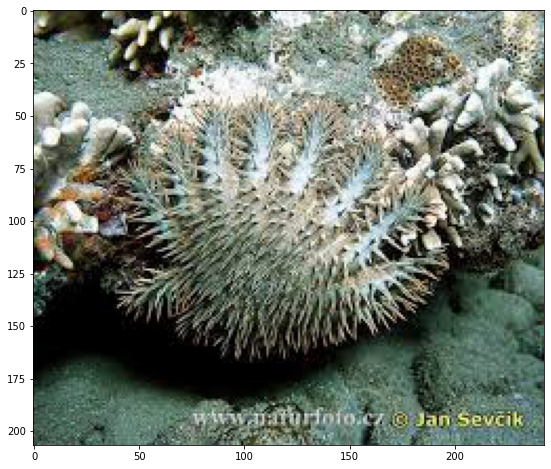

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# Use javascipt to take a photo.
def take_photo(filename, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  take_photo('/content/images.jpg')
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Use the captured photo to make predictions
%matplotlib inline

import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as PImage
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util

# Load the labels
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)

# Load the model
path_to_frozen_graph = os.path.join(EXPORTED_PATH, 'frozen_inference_graph.pb')
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(path_to_frozen_graph, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    image = PImage.open('/content/images.jpg')
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    (boxes, scores, classes, num) = sess.run(
        [detection_boxes, detection_scores, detection_classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)

# Convert the model
Once we have have the TensorFlow graph proto we can use it in Python, but we are going to take it a step further and convert the model to TensorFlow.js so we can use it directly in the browser.

The model only detects objects as the IDs in out `label_map.pbtxt` so we also need to create a json list of all of our labels so we can map the ID back to a label.

In [ ]:
!tensorflowjs_converter \
  --input_format=tf_frozen_model \
  --output_format=tfjs_graph_model \
  --output_node_names='Postprocessor/ExpandDims_1,Postprocessor/Slice' \
  --quantization_bytes=1 \
  --skip_op_check \
  $EXPORTED_PATH/frozen_inference_graph.pb \
  /content/model_web

import json

from object_detection.utils.label_map_util import get_label_map_dict

label_map = get_label_map_dict(LABEL_MAP_PATH)
label_array = [k for k in sorted(label_map, key=label_map.get)]

with open(os.path.join('/content/model_web', 'labels.json'), 'w') as f:
  json.dump(label_array, f)

!cd /content/model_web && zip -r /content/model_web.zip *

2022-01-31 22:20:03.820158: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:786] Optimization results for grappler item: graph_to_optimize
2022-01-31 22:20:03.820220: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:788]   debug_stripper: Graph size after: 3423 nodes (0), 4137 edges (0), time = 2.411ms.
2022-01-31 22:20:03.820231: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:788]   model_pruner: Graph size after: 2258 nodes (-1165), 2584 edges (-1553), time = 19.545ms.
2022-01-31 22:20:03.820240: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:788]   constant_folding: Graph size after: 1078 nodes (-1180), 1208 edges (-1376), time = 326.096ms.
2022-01-31 22:20:03.820250: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:788]   arithmetic_optimizer: Graph size after: 598 nodes (-480), 1192 edges (-16), time = 227.654ms.
2022-01-31 22:20:03.820258: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:788]   dependency_optimizer: Graph size after:

# Download the model
> **Note:** Sometimes this command doesn't run or it will throw an error. Just try running it again.

You can also download the model by right clicking on the `model_web.zip` file in the left sidebar file inspector.

In [ ]:
from google.colab import files
files.download('/content/model_web.zip') 

# Next steps / Using the model
Use the `model_web` folder generated here, with this [project](https://github.com/cloud-annotations/object-detection-react) to create a real-time webcam object detection app.